In [2349]:
import pandas as pd
import os
import csv
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from numpy import percentile
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import f_regression
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import StandardScaler

In [2350]:
def data_outlier(columns_list, df):

    data_out = pd.DataFrame(data = {'name': [], 'count': [], 'min': [], 'mean': [], 'max': [], 
                                    'low_range': [], 'upper_range': [], 'out_count': []
                                   })
    for column_name in columns_list:
        perc25 = percentile(df[column_name], 25)
        perc75 = percentile(df[column_name], 75)
        iqr = perc75 - perc25
        low_range = perc25 - 1.5 * iqr
        upper_range = perc75 + 1.5 * iqr
        out_count = df[column_name].apply(
            lambda x: None if x < low_range or x > upper_range else x).isna().sum()
        
        to_append = [column_name, df[column_name].count(), round(df[column_name].min(), 2), 
                     round(df[column_name].mean(), 2), round(df[column_name].max(), 2), 
                     round(low_range, 2), round(upper_range, 2), out_count]
        data_out_length = len(data_out)
        data_out.loc[data_out_length] = to_append
        
    return data_out

In [2351]:
# Рассмотрим как распределены числовые признаки в трейне

def train_hist_plot(column_name, df_train):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    new_series_log = np.log(df_train[column_name] + 1)

    ax[0].hist(df_train[column_name], rwidth=0.9, alpha=0.7, bins=15)
    ax[0].set_title(column_name)

    ax[1].hist(new_series_log, rwidth=0.9, alpha=0.7, bins=15)
    ax[1].set_title('log of ' + column_name)

    plt.show()
    
def test_hist_plot(column_name, df_test):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    new_series_log = np.log(df_test[column_name] + 1)

    ax[0].hist(df_test[column_name], rwidth=0.9, alpha=0.7, bins=15)
    ax[0].set_title(column_name)

    ax[1].hist(new_series_log, rwidth=0.9, alpha=0.7, bins=15)
    ax[1].set_title('log of ' + column_name)

    plt.show()

In [2352]:
def preproc_data(df_input, cat_features):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()

    ################### Categorical Features ##############################################################

    for column in cat_features:
         df_output[column] = df_output[column].astype('category').cat.codes
        
    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(df_output, columns=cat_features, dummy_na=False)

    return df_output



In [2353]:
# df = pd.read_csv("/data_new.csv", sep=",", quoting=csv.QUOTE_ALL, encoding='utf-8')

df = pd.read_csv("data_new.csv")

In [2354]:
df.head()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


In [2355]:
df.shape

(377185, 18)

In [2356]:
df[df['target'].isna()].shape

(2481, 18)

In [2357]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

In [2358]:
print("Percent NULL values\n")
round(df.isna().sum() / df.shape[0] * 100, 2)

Percent NULL values



status          10.58
private pool    98.89
propertyType     9.21
street           0.00
baths           28.19
homeFacts        0.00
fireplace       72.66
city             0.01
schools          0.00
sqft            10.76
zipcode          0.00
beds            24.20
state            0.00
stories         39.96
mls-id          93.39
PrivatePool     89.31
MlsId           17.73
target           0.66
dtype: float64

Удаляем столбцы, где процент NULL значений больше 40%

In [2359]:
df.drop(['private pool', 'fireplace', 'mls-id', 'PrivatePool'], axis=1, inplace=True)

In [2360]:
df.nunique()

status             159
propertyType      1280
street          337076
baths              229
homeFacts       321009
city              2026
schools         297365
sqft             25405
zipcode           4549
beds              1184
state               39
stories            348
MlsId           232944
target           43939
dtype: int64

status

In [2361]:
df['status'] = df['status'].str.lower()

In [2362]:
import string
string.punctuation
string.digits

'0123456789'

In [2363]:
df['status'] = df['status'].str.replace('[{}]'.format(string.punctuation), ' ').str.replace('[{}]'.format(string.digits), ' ').apply(lambda x: " ".join(str(x).split()))
df['status'] = df['status'].apply(lambda x: None if x is None else None if str(x) == 'nan' else x)
df['status'].value_counts(dropna=False)

for sale                   199571
active                     105207
NaN                         39918
foreclosure                  6769
new construction             5475
                            ...  
pending w escape clause         1
pending bring backup            1
pending w backup wanted         1
conting accpt backups           1
under contract w bckp           1
Name: status, Length: 104, dtype: int64

In [2364]:
df['status'].nunique()

103

In [2365]:
df['status'].isna().sum()

39918

propertyType 

In [2366]:
df['propertyType'].sample(10)

342107    single-family home
2837               Townhouse
20267            Traditional
190240          multi-family
112797    Single Family Home
18490              townhouse
100899    single-family home
247135    Single Family Home
220607             High Rise
353436    Urban Contemporary
Name: propertyType, dtype: object

In [2367]:
df['propertyType'] = df['propertyType'].str.lower()
df['propertyType'] = df['propertyType'].str.replace('[{}]'.format(string.punctuation), ' ').apply(lambda x: " ".join(str(x).split()))
df['propertyType'] = df['propertyType'].str.replace('one', '1').str.replace('two', '2')

In [2368]:
df['propertyType'].value_counts()[20:40]

contemporary modern           1010
apartment                      922
2 stories                      911
mfd mobile home                792
single detached                751
detached 2 story               638
2 story                        596
transitional                   560
cooperative                    535
florida                        530
bungalow                       442
farms ranches                  371
garden home                    305
cape cod                       281
2 stories traditional          280
spanish mediterranean          272
other style                    249
1 story traditional            238
other                          232
condo townhome traditional     225
Name: propertyType, dtype: int64

In [2369]:
df['stories_dop'] = df['propertyType'].str.findall(r'[a-z0-9]+ story|[a-z0-9]+ stories').apply(lambda x: None if len(x) == 0 else x[-1])
#.str.replace('one', '1').str.replace('two', '2')
df['stories_dop'].value_counts(dropna=False)

NaN          369527
1 story        4440
2 stories      1558
2 story        1466
3 stories       134
8 stories        38
7 stories        15
3 story           6
5 story           1
Name: stories_dop, dtype: int64

In [2370]:
set_story = set(df['stories_dop'].dropna())
for y in set_story:
  df['propertyType'] = df['propertyType'].str.replace(y, '')

In [2371]:
df[df['propertyType'].str.contains('home')]['propertyType'].value_counts()

single family home                                                                 123934
condo townhome row home co op                                                        7701
multi family home                                                                    1501
mfd mobile home                                                                       792
garden home                                                                           305
                                                                                    ...  
condo townhome hi rise contemporary modern mid century modern other see remarks         1
designated historical home single detached traditional                                  1
condo townhome southwestern                                                             1
mobile home                                                                             1
condo townhome mediterranean spanish                                                    1
Name: prop

In [2372]:
df['propertyType'] = df['propertyType'].str.replace('home', '')
df['propertyType'] = df['propertyType'].apply(lambda x: None if x == '' else
                                              None if str(x) == 'nan' else 
                                              None if str(x) == 'None' else " ".join(str(x).split()))

In [2373]:
df['propertyType'].nunique()

1112

In [2374]:
df['propertyType'].value_counts(dropna=False)

single family                                              186803
condo                                                       42530
NaN                                                         38211
lot land                                                    20552
townhouse                                                   18401
                                                            ...  
loft a frame                                                    1
courtyard custom other                                          1
condo town mediterranean other see remarks                      1
single detached a frame contemporary modern traditional         1
manuf mobile ranch                                              1
Name: propertyType, Length: 1113, dtype: int64

street

In [2375]:
df['street'].value_counts(dropna=False)[1200:]

303 Pradera Butte                    3
Parker Road E & Washington Street    3
Springfield Rd                       3
5528 John McDowell Place             3
8910 Echo Valley Dr                  3
                                    ..
1752 Carlyle Rd                      1
2845 NE 9th St #602                  1
5789 Birds Nest Ln                   1
1181 Monte Sereno Dr                 1
1426 Chestnut Springs Ln             1
Name: street, Length: 335877, dtype: int64

In [2376]:
df['street'] = df['street'].str.lower()
df['street'] = df['street'].apply(lambda x: None if 'not disclosed' in str(x) else 
                                  None if 'undisclosed' in str(x) else
                                  None if 'not available' in str(x) else
                                  None if 'unknown' in str(x) else str(x))

In [2377]:
df.loc[(df['street'].isna()==False) & (df['street'].str.contains(r'mls ')), 'street'] = None

In [2378]:
df.loc[81361, 'street']

'1131 w 24th street st unit c '

In [2379]:
punct = string.punctuation
df['street'] = df['street'].str.replace('[{}]'.format(string.punctuation), ' ').str.replace(r'\b[0-9]+\b', '').str.replace('  ', ' ').str.strip()

In [2380]:
street_list_tuple = [('st', 'street'), ('dr', 'drive'), ('ave', 'avenue'), ('rd', 'road'), ('rdg', 'ridge'), ('blvd', 'boulevard'), ('pkwy', 'parkway'), 
                   ('cir', 'circle'), ('hwy', 'highway'), ('ln', 'lane'), ('lndg', 'landing'), ('trl', 'trail'), ('ter', 'terrace'), ('ct', 'court'), 
                   ('crk', 'creek'), ('pl', 'place'), ('rds', 'roads'), ('bnd', 'bend'), ('fls', 'falls'), ('clf', 'cliff'), ('clfs', 'cliff'), ('mtn', 'mountain'), 
                   ('crst', 'crest'), ('hl', 'hill'), ('ml', 'mill'), ('mnr', 'manor'), ('hts', 'heights')]       
                          

In [2381]:
def street_replace(df, st_tupl):

  # Функция замены коротких синонимов на полные названия и удаление дубликатов

  df['street'] = df['street'].str.replace(rf'\b{st_tupl[0]}\b', st_tupl[1]).str.replace(rf'\b{st_tupl[1]}\b \b{st_tupl[1]}\b', st_tupl[1])
  df['street'] = df['street'].str.replace('  ', ' ').str.strip()

  # print(f'replace {st_tupl[0]} to {st_tupl[1]}')

In [2382]:
# for x in street_list_tuple:
#   street_replace(df, x)

In [2383]:
def del_dropwords_street(df, dropword):

  # Удаляем dropword из признака street
  df['street'] = df['street'].str.replace(rf'\b{dropword}\b', '').str.replace(r'  ', ' ').str.strip()

  print(f"Drop {dropword}")

In [2384]:
dropwords = ['lot', 'lots', 'collections', 'collection', 'plan', 'apt', 'unit', 'buildable', 'the']

# for x in dropwords:
#   del_dropwords_street(df, x)

In [2385]:
# Удаляем мусор из строк, чтобы легче паттерны было выделять
df['street'] = df['street'].str.replace(r'\b[a-z]{1,2}\b', '').str.replace('  ', ' ').str.strip()
df['street'] = df['street'].str.replace(r'\b[0-9]+[a-z]\b', '').str.replace(r'\b[a-z]+[0-9]\b', '').str.replace(r'\b[0-9]+ft\b', '')
df['street'] = df['street'].str.replace(r'  ', ' ').str.strip()

In [2386]:
df['street'] = df['street'].apply(lambda x: None if x is None else
                                  None if x.strip() == '' else x)

In [2387]:
df['street'].sample(10)

188685       deer unit
121821            None
157938        74th ter
15047      collins ave
78164     division ave
93014          victory
297911      washington
10078             21st
357658       wild fern
29181        sugarloaf
Name: street, dtype: object

In [2388]:
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 10000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 10

In [2389]:
street_nlp = df[df['street'].isna() == False]['street'].copy()

In [2390]:
# tokenize = Tokenizer(num_words=MAX_WORDS)
# tokenize.fit_on_texts(street_nlp)

baths

In [2391]:
df['baths'] = df['baths'].apply(lambda x: None if x is np.nan else x)
df['baths'].value_counts(dropna=False)

NaN           106338
2 Baths        52466
3 Baths        35506
2              20452
2.0            16576
               ...  
30.0               1
1.8 Baths          1
4.75 Baths         1
41.0               1
39 Baths           1
Name: baths, Length: 230, dtype: int64

In [2392]:
punct = '~—\-:'

In [2393]:
df['baths'] = df['baths'].str.lower().str.replace('[a-z]+\.?', '').str.replace(',', '.').str.replace('[{}]'.format(punct), ' ')
df['baths'] = df['baths'].apply(lambda x: None if str(x).strip() =='' else x)

In [2394]:
df['baths_new'] = df['baths'].str.findall('[0-9]+\.?[0-9]*')
df['baths_new'] = df['baths_new'].apply(lambda x: None if x is None else x[0]).astype(float)
df['baths_new'].value_counts()

# df['baths_new'].to_csv('out.csv')
# ванна 0.5 проверить

2.0     103519
3.0      66683
4.0      26333
1.0      17787
2.5      13786
         ...  
1.8          1
64.0         1
14.5         1
0.5          1
42.0         1
Name: baths_new, Length: 84, dtype: int64

city

In [2395]:
df['city'] = df['city'].str.lower().str.strip()
df['city'] = df['city'].str.replace('\-', ' ')

In [2396]:
df['city'] = df['city'].str.replace(' city', '').str.replace(' town+[a-z]*', '')
df['city'] = df['city'].str.replace('st\.', 'saint').str.replace(' twp.', '').str.replace('e. ', '').str.replace('ft.', 'fort').str.replace('s.a.', 'san antonio')
df['city'] = df['city'].str.replace(' twp', '').str.replace(' vlg', ' village')
df['city'] = df['city'].str.replace(' hts', 'heights').str.replace(' pt', 'point').str.replace('pt ', 'port ')
df['city'] = df['city'].str.replace('^st ', 'saint ')

In [2397]:
df.loc[(df['city'].isna()==False) & (df['city'].str.contains('san antonio')), 'city'] = 'san antonio'

In [2398]:
df['city'] = df['city'].str.replace('p c ', 'panama ').str.replace('^n ', 'north ').str.replace("town 'n' country", 'town north country')
df['city'] = df['city'].str.replace('nyork', 'new york').str.replace('nyc', 'new york')
df['city'] = df['city'].str.replace('bed-stuy', 'brooklyn').str.replace('collegepoint', 'college point')
df['city'] = df['city'].str.replace('othvalue [ a-z]*', 'other')

In [2399]:
df['city'] = df['city'].apply(lambda x: " ".join(str(x).split())).str.strip()
df['city'] = df['city'].apply(lambda x: None if x is None else None if str(x) == '' else x)

In [2400]:
df['city'].value_counts(dropna=False)

san antonio      30033
houston          24442
miami            15528
jacksonville     10032
dallas            8858
                 ...  
springport           1
manvel               1
encinal              1
white cottage        1
clarksburg           1
Name: city, Length: 1784, dtype: int64

sqft

In [2401]:
df['sqft'].value_counts()

0                                          11854
1,200 sqft                                   839
1,000 sqft                                   654
1,100 sqft                                   573
1,800 sqft                                   563
                                           ...  
5,252                                          1
127,961 sqft                                   1
Total interior livable area: 3,887 sqft        1
7,527 sqft                                     1
6,064 sqft                                     1
Name: sqft, Length: 25405, dtype: int64

In [2402]:
df['sqft'] = df['sqft'].apply(lambda x: None if x is np.nan else x)

In [2403]:
df['sqft'] = df['sqft'].str.replace('[a-z ]*: ', '')
df['sqft'] = df['sqft'].str.replace('-','').str.replace('[A-Za-z]+','').str.replace(',','')

In [2404]:
df['sqft'] = df['sqft'].str.strip().apply(lambda x: None if x is None else 
                                          None if x == '' else int(x))

In [2405]:
df['sqft'].value_counts(dropna=False)

NaN         41397
0.0         11854
1200.0       1426
1000.0       1027
1500.0       1014
            ...  
8966.0          1
11089.0         1
123275.0        1
44351.0         1
32767.0         1
Name: sqft, Length: 9898, dtype: int64

zipcode

In [2406]:
df['zipcode'].value_counts()

32137         2141
33131         1563
34747         1488
78245         1390
34759         1333
              ... 
27607-4176       1
77535            1
41822            1
07004-1878       1
27703-9840       1
Name: zipcode, Length: 4549, dtype: int64

In [2407]:
# Приведем все значения к 5-значному формату

df['zipcode'] = df['zipcode'].str.replace('\-[0-9]*', '').apply(lambda x: None if x is None else 
                                                                None if x == '' else 
                                                                ('0000' + str(x))[-5:])

beds

In [2408]:
df['beds'] = df['beds'].apply(lambda x: None if x is np.nan else x).str.lower()

In [2409]:
df['beds'].value_counts(dropna=False)

NaN            91282
3 beds         53459
4 beds         35418
3              31406
2 beds         26362
               ...  
2.32 acres         1
5,026 sqft         1
9,273 sqft         1
2,570 sqft         1
23.56 acres        1
Name: beds, Length: 1185, dtype: int64

In [2410]:
index_sqft = df.loc[(df['sqft'].isna()) & (df['beds'].str.contains('sqft')), ['sqft','beds']].index
new_sqft = df.loc[(df['sqft'].isna()) & (df['beds'].str.contains('sqft')), ['sqft','beds']]
new_sqft['sqft'] = new_sqft['beds'].str.strip().str.replace(',', '.').str.findall('[0-9]+\.*[0-9]*').apply(lambda x: None if len(x) == 0 else x[0]).astype(float)

df.loc[(df['sqft'].isna()) & (df['beds'].str.contains('sqft')), 'sqft'] = new_sqft['sqft']
df.loc[(df['beds'].isna()==False) & (df['beds'].str.contains('sqft')), 'beds'] = None

In [2411]:
index_sqft = df.loc[(df['sqft'].isna()) & (df['beds'].str.contains('acre')), ['sqft','beds']].index
new_sqft = df.loc[(df['sqft'].isna()) & (df['beds'].str.contains('acre')), ['sqft','beds']]
new_sqft['sqft'] = new_sqft['beds'].str.strip().str.replace(',', '.').str.findall('[0-9]+\.*[0-9]*').apply(lambda x: None if len(x) == 0 else x[0]).astype(float)
new_sqft['sqft'] = (new_sqft['sqft'] * 43560).astype(int)

df.loc[(df['sqft'].isna()) & (df['beds'].str.contains('acre')), 'sqft'] = new_sqft['sqft']
df.loc[(df['beds'].isna()==False) & (df['beds'].str.contains('acre')), 'beds'] = None

In [2412]:
df['beds'] = df['beds'].str.replace('bedrooms', 'beds').str.replace('bd', 'beds')

In [2413]:
df.loc[(df['beds'].isna()==False) & (df['beds'].str.strip().str.contains('^[a-z,\-%@#_:;~ ]+$')), 'beds'] = None

In [2414]:
df['beds'].value_counts(dropna=False)[:20]

C:\Users\Files\Anaconda3\lib\site-packages\IPython\core\displayhook.py:276: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  'Flushing oldest {cull_count} entries.'.format(sz=sz, cull_count=cull_count))


NaN       111390
3 beds     66336
4 beds     43683
2 beds     31605
3          31406
4          20030
2          16110
5 beds     13904
3.0         8088
5           6424
4.0         5231
1           4610
6 beds      4466
2.0         2430
6           1806
5.0         1372
7 beds      1247
0           1230
1 beds      1081
8 beds       856
Name: beds, dtype: int64

In [2415]:
new_bath = df.loc[(df['baths_new'].isna()) & (df['beds'].str.contains('bath')), 'beds'].str.findall('[0-9a-z ]+ bath').apply(lambda x: x[0].split()[0]).astype(float)
df.loc[new_bath.index, 'baths_new'] = new_bath
df.loc[new_bath.index, 'baths_new']

18787     1.0
124819    1.0
172605    1.0
238222    1.0
279149    2.0
325249    1.0
Name: baths_new, dtype: float64

In [2416]:
new_beds = pd.concat([(df.loc[(df['beds'].isna()==False) & (df['beds'].str.strip().str.contains('[0-9 a-z]+bed[a-z]*,')), 'beds']),
                      df.loc[(df['beds'].isna()==False) & (df['beds'].str.strip().str.contains(',[0-9 a-z]+bed[a-z]*')), 'beds']
                      ],
                     ).reset_index()
new_beds = new_beds.drop_duplicates().set_index('index')
new_beds['beds'] = new_beds['beds'].str.replace('or more ', '').str.findall('[0-9 ]+bed').apply(lambda x: x[0].split()[0]).astype(float)

df.loc[new_beds.index, 'beds'] = new_beds['beds']
df.loc[new_beds.index, 'beds']

index
18787     2
172605    2
200331    3
238222    3
325249    2
124819    2
279149    3
Name: beds, dtype: object

In [2417]:
punct = '!@#_,:;&'
df.loc[(df['beds'].isna()==False) & (df['beds'].str.contains('[{}]'.format(punct))), 'beds'] = None
punct = '\-'
new_beds = df.loc[(df['beds'].isna()==False) & (df['beds'].str.contains('[{}]'.format(punct))), 'beds'].str.findall('[0-9]+').apply(lambda x: x[-1]).astype(float)
df.loc[new_beds.index, 'beds'] = new_beds
df.loc[new_beds.index, 'beds']

330468    2
Name: beds, dtype: object

In [2418]:
df['beds'] = df['beds'].str.replace('or more ', '')
df['beds'] = df['beds'].str.replace('beds','').str.strip().apply(lambda x: None if x is None else
                                                                 None if x == '' else x).astype(float)

state

In [2419]:
df['state'].value_counts(dropna=False)[-20:]

UT    1325
MD    1090
VT     868
MO     866
VA     801
WI     452
NJ     436
ME     259
IA     242
KY      90
OK      49
MS      40
SC      28
MT       7
DE       5
Fl       1
OT       1
BA       1
AL       1
OS       1
Name: state, dtype: int64

stories

In [2420]:
df['stories_dop'] = df['stories_dop'].apply(lambda x: None if x is None else x.split()[0]).astype(float)
df['stories_dop'].value_counts()

1.0    4440
2.0    3024
3.0     140
8.0      38
7.0      15
5.0       1
Name: stories_dop, dtype: int64

In [2421]:
df['stories'] = df['stories'].str.lower()
df['stories'].value_counts(dropna=False)

# много пустых значений, не знаю, обрабатывать ли их

NaN                                 150715
1.0                                  67454
2.0                                  55283
1                                    23086
2                                    18146
                                     ...  
1 story, split level                     1
tri/multi level                          1
one, two, multi/split                    1
log                                      1
2 level, site built, split foyer         1
Name: stories, Length: 349, dtype: int64

In [2422]:
# punct = '!|/_\-:;'
# df.loc[(df['stories'].isna()==False) & (df['stories'].str.contains('[{}]'.format(punct))), 'stories'].value_counts()
# df.loc[(df['stories'].isna()==False) & (df['stories'].str.contains('[0-9 ]/[0-9 ]')), 'stories'].value_counts()
# df.loc[(df['stories'].isna()==False) & (df['stories'].str.contains('half')), 'stories'].value_counts()
# df.loc[(df['stories'].isna()==False) & (df['stories'].str.contains('multi')), 'stories'].value_counts()


MlsId

In [2423]:
df = df.drop('MlsId', axis=1)

homeFacts

In [2424]:
df['homeFacts'] = df['homeFacts'].apply(lambda x: eval(x))

In [2425]:
df['homeFacts_new'] = df['homeFacts'].apply(lambda x: list(x.values())[0])

In [2426]:
list_columns = ['Year built', 'Remodeled year', 'Heating', 'Cooling', 'Parking', 'lotsize', 'Price/sqft']

for column in enumerate(list_columns):
  df[column[1]] = None
  df[column[1]] = df['homeFacts_new'].apply(lambda x: None if x[column[0]].get('factValue') == '' else  x[column[0]].get('factValue'))

Year built

In [2427]:
df['Year built'].value_counts(dropna=False)

NaN     62374
2019    32171
2006     8008
2005     7503
2007     7152
        ...  
1823        1
1845        1
1019        1
1843        1
1788        1
Name: Year built, Length: 230, dtype: int64

In [2428]:
df['Year built'] = df['Year built'].apply(lambda x: None if x is None else
                                          None if 'No' in x else int(x))

In [2429]:
df['Year built'].value_counts(dropna=False)

NaN       63596
2019.0    32171
2006.0     8008
2005.0     7503
2007.0     7152
          ...  
1805.0        1
1807.0        1
1808.0        1
1809.0        1
1019.0        1
Name: Year built, Length: 229, dtype: int64

Remodeled year

In [2430]:
df['Remodeled year'].value_counts(dropna=False)

# Слишком много пропусков, удалим потом столбец

NaN     226110
2006      5538
2005      4817
2007      4387
2008      3796
         ...  
1862         1
1111         1
1738         1
1888         1
1845         1
Name: Remodeled year, Length: 154, dtype: int64

Heating

In [2431]:
df['Heating'].value_counts(dropna=False)[:10]

# Слишком много пропусков и непоказательных данных, удалим потом столбец

NaN                 109332
Forced Air           82807
Forced air           51506
Other                29623
Electric             10211
Gas                   9296
No Data               8611
Central Air           7814
Central Electric      7112
Central               6247
Name: Heating, dtype: int64

Cooling

In [2432]:
df['Cooling'].value_counts(dropna=False)

# Слишком много пропусков и непоказательных данных, удалим потом столбец

Central                                                                                   158754
NaN                                                                                       123967
Central Air                                                                                14384
No Data                                                                                    10616
Has Cooling                                                                                 9730
                                                                                           ...  
Heat Pump, Window Unit                                                                         1
Central Air, Gas (Hot Air), Heat Pump for A/C, Humidifier, Multi-Zone A/C, Natural Gas         1
Central Heat (Electric), Central Heat (Gas), Window Unit                                       1
Both Refrig & Evap, Ceiling Fan(s), Programmable Thmstat                                       1
Central Cooling, Paddle Fans, 

Parking

In [2433]:
df['Parking'].value_counts(dropna=False)[:10]

# Слишком много пропусков и непоказательных данных, удалим потом столбец

NaN                         175420
Attached Garage              70752
2 spaces                     28063
1 space                      14252
No Data                      13334
Detached Garage              13201
Carport                       7743
3 spaces                      4724
Off Street                    3622
Carport, Attached Garage      3025
Name: Parking, dtype: int64

lotsize sqft

In [2434]:
df[['lotsize', 'sqft']].sample(5)

,lotsize,sqft
113901,0.36 acres,3620.0
361827,0.33 acres,2173.0
43706,"3,049 sqft lot",3603.0
279152,0.43 Acres,3004.0
66007,"8,276 sqft",3163.0


In [2435]:
df['lotsize'] = df['lotsize'].str.lower().str.replace(r'[\-,—]', '').str.strip().apply(lambda x: None if x is None else
                                                                                      None if 'no' in x else
                                                                                      None if x == '' else x)

In [2436]:
# Заполним те значения признака sqft которые пустые из признака lotsize

# acres
new_lot_size = df.loc[(df['sqft'].isna()) & (df['lotsize'].isna()==False) & (df['lotsize'].str.contains('sq'))]['lotsize']
new_lot_size = new_lot_size.str.lower().str.replace(r'[a-z \.]', '').str.strip()
new_lot_size = new_lot_size.apply(lambda x: None if x is None else 
                                  None if x is np.nan else
                                  None if x == '' else int(float(x)))
df.loc[new_lot_size.index, 'sqft'] = new_lot_size

# acres
new_lot_size = df.loc[(df['sqft'].isna()) & (df['lotsize'].isna()==False) & (df['lotsize'].str.contains('acre'))]['lotsize']
new_lot_size = new_lot_size.str.lower().str.replace('[a-z ]', '').str.strip()
new_lot_size = new_lot_size.apply(lambda x: None if x is None else float(x) * 43560).astype(int)
df.loc[new_lot_size.index, 'sqft'] = new_lot_size

# Другие!

In [2437]:
df['sqft'].isna().sum()

11890

Price/sqft

In [2438]:
df['Price/sqft'].sample(10)

270617         $214/sqft
185341              None
167240    $239 / Sq. Ft.
82782               None
19433               None
160683              None
146061              None
251191    $209 / Sq. Ft.
104294              None
211509              None
Name: Price/sqft, dtype: object

In [2439]:
df['Price/sqft'] = df['Price/sqft'].str.lower().str.replace(r'[,/$a-z\. ]', '').str.strip().apply(lambda x: None if x is None else
                                                                                      None if x == '' else int(x))

schools

In [2440]:
df['schools'] = df['schools'].apply(lambda x: eval(x)[0])

In [2441]:
list_keys = ['data', 'name', 'rating']
# name не будем брать

list_columns = ['Distance', 'Grades', 'rating']
# Grades не будем брать слишком запутано

df['Distance'] = df['schools'].apply(lambda x: None if x.get('data').get('Distance') is None else x.get('data').get('Distance'))
df['rating'] = df['schools'].apply(lambda x: None if x.get('rating') is None else x.get('rating'))

In [2442]:
df['Distance'] = df['Distance'].apply(lambda x: [float(y.replace('mi', '').strip()) for y in x])

In [2443]:
df['Distance'] = df['Distance'].apply(lambda x: list(filter(None, x)))

In [2444]:
df['Distance'].sample(10)

338870                                         [0.14, 1.71]
166438                                      [0.1, 0.7, 1.3]
321217                                      [0.8, 0.9, 1.6]
292985    [3.93, 1.93, 6.23, 8.37, 1.62, 3.04, 10.37, 9....
174210                                 [0.4, 0.2, 0.2, 1.2]
73170                                    [4.27, 3.28, 3.41]
156901                                      [0.4, 3.1, 1.7]
257555                                   [1.48, 1.86, 1.46]
341857                       [0.76, 7.91, 3.61, 4.13, 0.82]
249844                                   [1.18, 2.29, 1.42]
Name: Distance, dtype: object

In [2445]:
df['rating'] = df['rating'].apply(lambda x: [None if "NR" in str(y) else
                                             None if "None" in str(y) else
                                             None if "NA" in str(y) else
                                             None if str(y) == '' else
                                             int(str(y).split('/')[0]) if "/" in str(y) else
                                             int(y) for y in x])

In [2446]:
df['rating'] = df['rating'].apply(lambda x: list(filter(None, x)))

In [2447]:
df['rating'].sample(10)

177598                [2, 3, 3]
248816                   [3, 4]
142580          [5, 6, 7, 6, 4]
323254    [9, 8, 3, 8, 9, 8, 8]
354117                [3, 4, 6]
237                   [4, 4, 2]
4663                  [7, 4, 3]
275848               [10, 5, 7]
106693                [7, 9, 7]
277569                [3, 4, 3]
Name: rating, dtype: object

target

In [2448]:
df['target'].value_counts(dropna=False)

NaN         2481
$225,000    1462
$275,000    1355
$250,000    1312
$350,000    1296
            ... 
223,305        1
$136,200       1
$170,042       1
$409,248       1
$283,065       1
Name: target, Length: 43940, dtype: int64

In [2449]:
df['target'] = df['target'].apply(lambda x: None if x is np.nan else x)

In [2450]:
df[(df['target'].isna()==False) & (df['target'].str.isdigit())]['target'].value_counts()

1      2
800    2
3      2
20     1
8      1
25     1
29     1
750    1
30     1
825    1
Name: target, dtype: int64

In [2451]:
punct = '$,+\-/'
df['target'] = df['target'].str.replace('[a-z]', '').str.replace('[{}]'.format(punct), '').str.strip()

In [2452]:
df['target'] = df['target'].apply(lambda x: None if x is None else int(x.split()[0]))

In [2453]:
df.loc[330468]['target']

1215.0

In [2454]:
df['target'].value_counts(dropna=False)

NaN         2481
225000.0    1806
275000.0    1650
250000.0    1644
350000.0    1641
            ... 
9100.0         1
515530.0       1
195050.0       1
780226.0       1
374521.0       1
Name: target, Length: 34233, dtype: int64

target Price/sqft

In [2455]:
# Заполним те значения признака sqft которые пустые из признака Price/sqft и признака target

new_lot_size = df.loc[(df['sqft'].isna()) & (df['target'].isna()==False) & (df['Price/sqft'].isna()==False)][['Price/sqft', 'target']]
new_lot_size['sqft'] = (new_lot_size['target'] / new_lot_size['Price/sqft']).astype(int)
df.loc[new_lot_size.index, 'sqft'] = new_lot_size['sqft']

# Заполним те значения признака Price/sqft которые пустые из признака sqft и признака target

new_prsq = df.loc[(df['sqft'].isna()==False) & (df['target'].isna()==False) & (df['Price/sqft'].isna())][['sqft', 'target']]
new_prsq['Price/sqft'] = round(new_prsq['target'] / new_prsq['sqft'])
df.loc[new_prsq.index, 'Price/sqft'] = new_prsq['Price/sqft']

future engeneer

In [2456]:
df.sample(5)

,status,propertyType,street,baths,homeFacts,city,schools,sqft,zipcode,beds,...,homeFacts_new,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,Price/sqft,Distance,rating
302490,for sale,townhouse,stirling,2,"{'atAGlanceFacts': [{'factValue': '1950', 'fac...",philadelphia,"{'rating': ['2/10', '1/10'], 'data': {'Distanc...",1200.0,19135,3.0,...,"[{'factValue': '1950', 'factLabel': 'Year buil...",1950.0,None,Forced Air,Wall,Attached Garage,1245 sqft,121.0,"[0.26, 1.4]","[2, 1]"
17021,for sale,condo,88th,3,"{'atAGlanceFacts': [{'factValue': '1927', 'fac...",new york,"{'rating': ['9/10', '8/10', '3/10', '8/10', '9...",2844.0,10128,3.0,...,"[{'factValue': '1927', 'factLabel': 'Year buil...",1927.0,None,None,Central,None,None,3428.0,"[3.66, 3.66, 0.45, 3.69, 6.06, 0.66, 0.35]","[9, 8, 3, 8, 9, 10, 7]"
220146,for sale,single family,cherum,2,"{'atAGlanceFacts': [{'factValue': '2000', 'fac...",las vegas,"{'rating': ['9/10', '8/10', 'None/10'], 'data'...",1911.0,89135,3.0,...,"[{'factValue': '2000', 'factLabel': 'Year buil...",2000.0,2000,Forced Air,Central,Attached Garage,5227 sqft,222.0,"[2.8, 0.37, 3.0]","[9, 8]"
243785,for sale,single family,albany,None,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",oak park,"{'rating': ['3/10'], 'data': {'Distance': ['0....",901.0,48237,3.0,...,"[{'factValue': '2019', 'factLabel': 'Year buil...",2019.0,None,Forced Air,Central,None,6098 sqft,155.0,[0.67],[3]
175634,None,single family,sunrise creek,2.0,"{'atAGlanceFacts': [{'factValue': '1985', 'fac...",san antonio,"{'rating': ['4/10', '3/10', '3/10'], 'data': {...",1022.0,78244,3.0,...,"[{'factValue': '1985', 'factLabel': 'Year buil...",1985.0,1989,Forced air,Central,2 spaces,4356 sqft,133.0,"[0.4, 1.3, 0.9]","[4, 3, 3]"


In [2457]:
df = df.drop(['stories_dop', 'homeFacts', 'schools', 'stories_dop', 'baths_new', 'homeFacts_new'], axis=1)

In [2458]:
round(df.isna().sum() / df.shape[0] * 100, 4)

status            10.5831
propertyType      10.1306
street             2.4240
baths             28.5902
city               0.0090
sqft               3.0577
zipcode            0.0005
beds              29.6544
state              0.0000
stories           39.9578
target             0.6578
Year built        16.8607
Remodeled year    59.9467
Heating           28.9863
Cooling           32.8664
Parking           46.5077
lotsize           24.4008
Price/sqft         3.5882
Distance           0.0000
rating             0.0000
dtype: float64

In [2459]:
df = df.drop(['lotsize'], axis=1)
df = df.drop(['stories', 'Remodeled year', 'Heating', 'Cooling', 'Parking'], axis=1)

In [2460]:
df = df.drop(['baths', 'beds', 'Year built'], axis=1)

In [2461]:
df[['status', 'propertyType', 'city', 'zipcode', 'state']].nunique()

status           103
propertyType    1112
city            1783
zipcode         4267
state             39
dtype: int64

In [2462]:
# Содаем новые признаки

import numpy as np

df['dist_max'] = df['Distance'].apply(lambda x: None if x is None else 
                                      None if len(x) == 0 else max(x))
df['dist_min'] = df['Distance'].apply(lambda x: None if x is None else 
                                      None if len(x) == 0 else min(x))
df['dist_mean'] = df['Distance'].apply(lambda x: None if x is None else 
                                      None if len(x) == 0 else round(np.mean(list(filter(None, x))), 2))

In [2463]:
df['rate_max'] = df['rating'].apply(lambda x: None if x is None else 
                                      None if len(x) == 0 else max(x))
df['rate_min'] = df['rating'].apply(lambda x: None if x is None else 
                                      None if len(x) == 0 else min(x))
df['rate_mean'] = df['rating'].apply(lambda x: None if x is None else 
                                      None if len(x) == 0 else round(np.mean(list(filter(None, x))), 2))

In [2464]:
df = df.drop(['Distance', 'rating'], axis=1)

In [2465]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   status        337267 non-null  object 
 1   propertyType  338974 non-null  object 
 2   street        368042 non-null  object 
 3   city          377151 non-null  object 
 4   sqft          365652 non-null  float64
 5   zipcode       377183 non-null  object 
 6   state         377185 non-null  object 
 7   target        374704 non-null  float64
 8   Price/sqft    363651 non-null  float64
 9   dist_max      372900 non-null  float64
 10  dist_min      372900 non-null  float64
 11  dist_mean     372900 non-null  float64
 12  rate_max      372033 non-null  float64
 13  rate_min      372033 non-null  float64
 14  rate_mean     372033 non-null  float64
dtypes: float64(9), object(6)
memory usage: 43.2+ MB


In [2466]:
df[df['target'].isna()].isna().sum()

# В столбце Price/sqft почти все значения null, удалим данный столбец

status           661
propertyType     180
street            21
city               5
sqft             128
zipcode            0
state              0
target          2481
Price/sqft      2129
dist_max          27
dist_min          27
dist_mean         27
rate_max          35
rate_min          35
rate_mean         35
dtype: int64

In [2467]:
df = df.drop(['Price/sqft'], axis=1)

Train Test

In [2468]:
df_train = df[df['target'].isna() == False].copy()
df_test = df[df['target'].isna()].copy()
df_test['target'] = 0

In [2469]:
df_train.head()

,status,propertyType,street,city,sqft,zipcode,state,target,dist_max,dist_min,dist_mean,rate_max,rate_min,rate_mean
0,active,single family,heather,southern pines,2900.0,28387,NC,418000.0,12.60,2.70,5.54,7.0,4.0,5.20
1,for sale,single family,heroy ave,spokane valley,1947.0,99216,WA,310000.0,1.65,1.01,1.33,4.0,4.0,4.00
2,for sale,single family,westridge,san antonio,3000.0,90049,CA,2895000.0,2.63,1.19,1.96,8.0,4.0,6.67
3,for sale,single family,livingston ave,dallas,6457.0,75205,TX,2395000.0,1.05,0.10,0.75,10.0,9.0,9.25
4,for sale,lot land,kiscoe,palm bay,10019.0,32908,FL,5000.0,5.96,3.03,4.08,5.0,4.0,4.67


In [2470]:
df_train.isna().sum()

# Мало значений null удалим их

status          39257
propertyType    38031
street           9122
city               29
sqft            11405
zipcode             2
state               0
target              0
dist_max         4258
dist_min         4258
dist_mean        4258
rate_max         5117
rate_min         5117
rate_mean        5117
dtype: int64

In [2471]:
df_train = df_train.dropna(axis=0)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290422 entries, 0 to 377182
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   status        290422 non-null  object 
 1   propertyType  290422 non-null  object 
 2   street        290422 non-null  object 
 3   city          290422 non-null  object 
 4   sqft          290422 non-null  float64
 5   zipcode       290422 non-null  object 
 6   state         290422 non-null  object 
 7   target        290422 non-null  float64
 8   dist_max      290422 non-null  float64
 9   dist_min      290422 non-null  float64
 10  dist_mean     290422 non-null  float64
 11  rate_max      290422 non-null  float64
 12  rate_min      290422 non-null  float64
 13  rate_mean     290422 non-null  float64
dtypes: float64(8), object(6)
memory usage: 33.2+ MB


In [2472]:
df_test.isna().sum()

# Мало нулевых значений, заполним их

status          661
propertyType    180
street           21
city              5
sqft            128
zipcode           0
state             0
target            0
dist_max         27
dist_min         27
dist_mean        27
rate_max         35
rate_min         35
rate_mean        35
dtype: int64

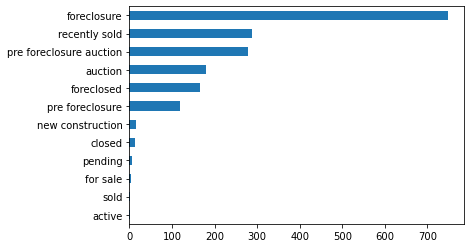

In [2473]:
df_test['status'].value_counts(ascending=True).plot.barh()

In [2474]:
# Заменим null значения
most_stat = df_test['status'].value_counts().index[0]

df_test.loc[df_test['status'].isna(), 'status'] = most_stat

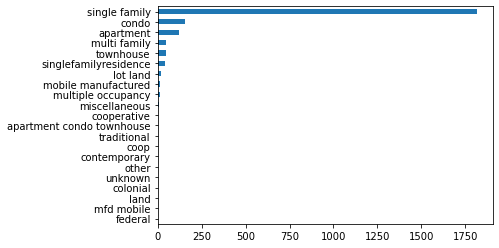

In [2475]:
df_test['propertyType'].value_counts(ascending=True).plot.barh()

In [2476]:
# Заменим null значения
most_prop = df_test['propertyType'].value_counts().index[0]

df_test.loc[df_test['propertyType'].isna(), 'propertyType'] = most_prop

In [2477]:
# Можно из трейна удалить те значения propertyType, которых нет в тесте и удалить их
# !!! на будущее

In [2478]:
df_test['street'].value_counts(dropna=False)[:10]

NaN         21
12th        10
1st          9
9th          8
7th          7
12th ave     7
avenue       7
8th          6
26th         6
harrison     6
Name: street, dtype: int64

In [2479]:
most_street = df_test['street'].value_counts().index[0]

df_test.loc[df_test['street'].isna(), 'street'] = most_street

In [2480]:
df_test.loc[df_test['city'].isna(), 'city'] = 'other'

In [2481]:
mean_sqft = round(df_test['sqft'].dropna().mean())

df_test.loc[df_test['sqft'].isna(), 'sqft'] = mean_sqft

In [2482]:
mean_dist_max = round(df_test['dist_max'].dropna().mean())

df_test.loc[df_test['dist_max'].isna(), 'dist_max'] = mean_dist_max

In [2483]:
mean_dist_min = round(df_test['dist_min'].dropna().mean())

df_test.loc[df_test['dist_min'].isna(), 'dist_min'] = mean_dist_max

In [2484]:
mean_dist_mean = round(df_test['dist_mean'].dropna().mean())

df_test.loc[df_test['dist_mean'].isna(), 'dist_mean'] = mean_dist_max

In [2485]:
mean_rate_max = round(df_test['rate_max'].dropna().mean())

df_test.loc[df_test['rate_max'].isna(), 'rate_max'] = mean_dist_max

In [2486]:
mean_rate_min = round(df_test['rate_min'].dropna().mean())

df_test.loc[df_test['rate_min'].isna(), 'rate_min'] = mean_dist_max

In [2487]:
mean_rate_mean = round(df_test['rate_mean'].dropna().mean())

df_test.loc[df_test['rate_mean'].isna(), 'rate_mean'] = mean_dist_max

In [2488]:
# Дополнительно выделить столбцы с Null значениями

Обработка финального датасета

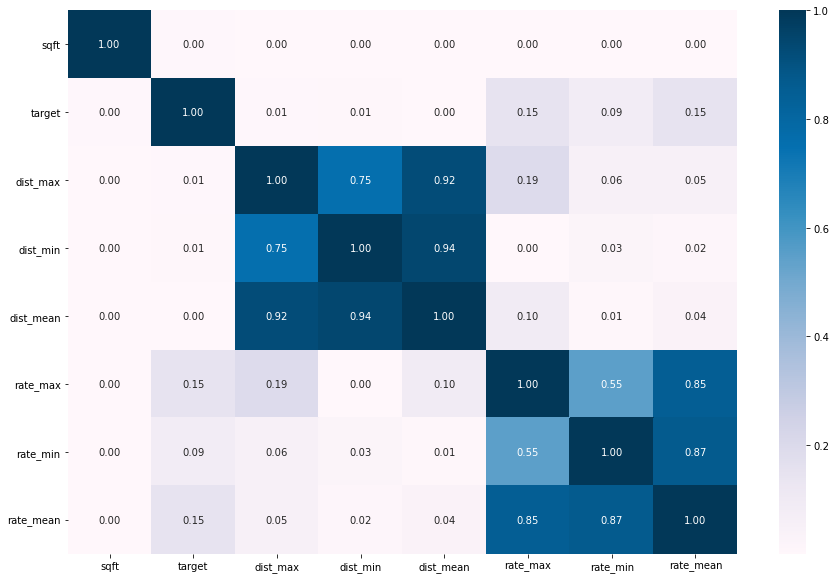

In [2489]:
# Рассмотрим матрицу корреляции для начального удаления сильно скоррелированных признаков

plt.figure(figsize=(15,10))

sns.heatmap(df_train.corr().abs(), annot=True, fmt='.2f', cmap='PuBu')
plt.yticks(rotation=0)
plt.show()

In [2490]:
# Удаляем mean значения из dist и rate
# Пока без токенайзера, поэтому не будем включать столбец street
# Задаем типы переменных

categorical_features = ['status', 'propertyType', 'city', 'zipcode', 'state']
numerical_features = ['sqft', 'dist_max', 'dist_min', 'rate_max', 'rate_min']
value = ['target']

In [2491]:
# Смотрим выбросы

data_out = data_outlier(numerical_features + value, df_train)
data_out

,name,count,min,mean,max,low_range,upper_range,out_count
0,sqft,290422.0,0.00,20540.00,7.959794e+08,-1060.00,5196.00,26917.0
1,dist_max,290422.0,0.02,4.69,1.591090e+03,-3.73,10.56,27791.0
2,dist_min,290422.0,0.01,1.19,1.590380e+03,-1.04,2.68,24800.0
3,rate_max,290422.0,1.00,6.63,1.000000e+01,0.50,12.50,0.0
4,rate_min,290422.0,1.00,3.66,1.000000e+01,-2.50,9.50,548.0
5,target,290422.0,1.00,613918.69,1.950000e+08,-391066.88,1151280.12,27776.0


Рассмотрим числовые признаки по-отдельности

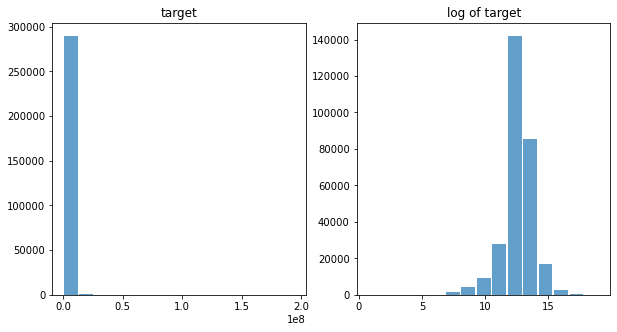

In [2492]:
# target

train_hist_plot('target', df_train)

In [2493]:
df_train['target_log'] = np.log(df_train['target'] + 1)
df_test['target_log'] = 0

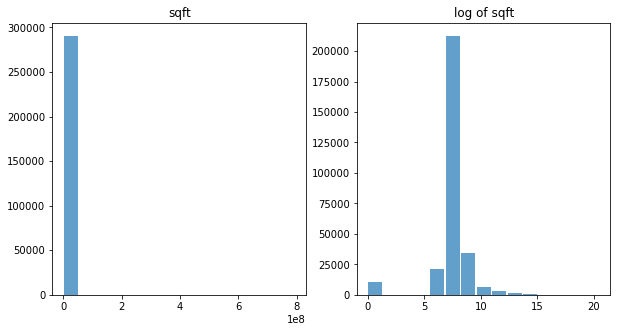

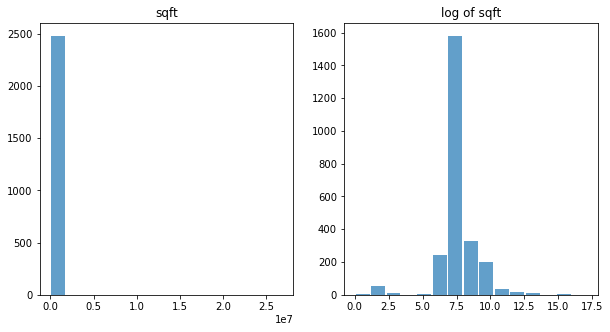

In [2494]:
# sqft

train_hist_plot('sqft', df_train)
test_hist_plot('sqft', df_test)

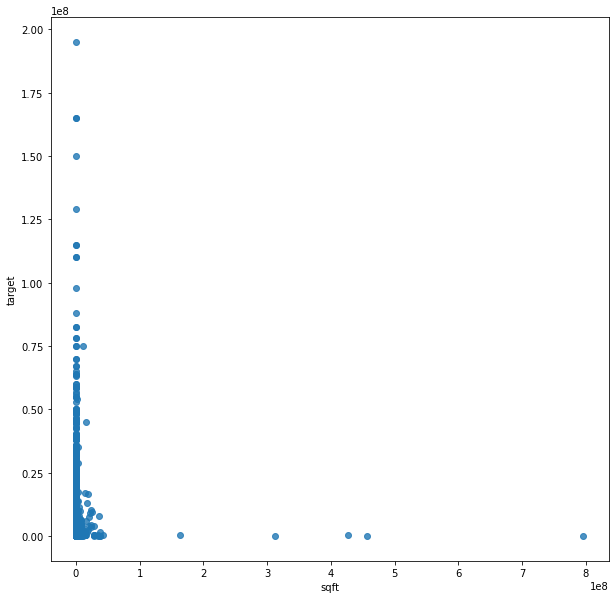

In [2495]:
plt.figure(figsize = (10,10))
sns.regplot(data=df_train, y="target", x="sqft", fit_reg=False)
plt.show()

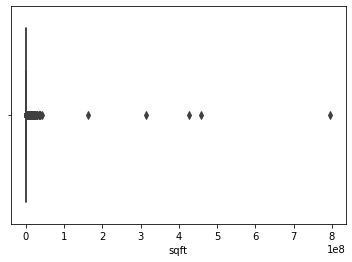

,name,count,min,mean,max,low_range,upper_range,out_count
0,sqft,290422.0,0.0,20540.0,795979430.0,-1060.0,5196.0,26917.0


In [2496]:
# График выбросов
sns.boxplot(x=df_train["sqft"])
plt.show()

# Выбросы
data_out[data_out['name'] == 'sqft']

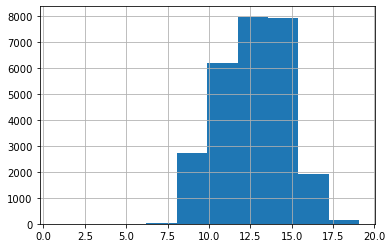

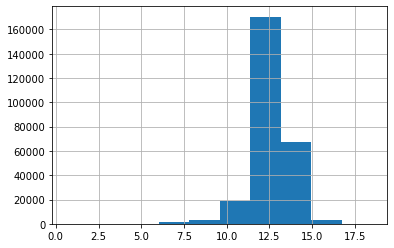

In [2497]:
# Посмотрим как распределена цена у выбросов и невыбросов в трейне
df_train[df_train['sqft'] > 5199.0]['target_log'].hist()
plt.show()

df_train[df_train['sqft'] <= 5199.0]['target_log'].hist()
plt.show()

In [2498]:
# Цена распределена примерно одинакого, ничего с выбросами делать пока не будем

In [2499]:
df_train['sqft_log'] = np.log(df_train['sqft'] + 1)
df_test['sqft_log'] = np.log(df_test['sqft'] + 1)

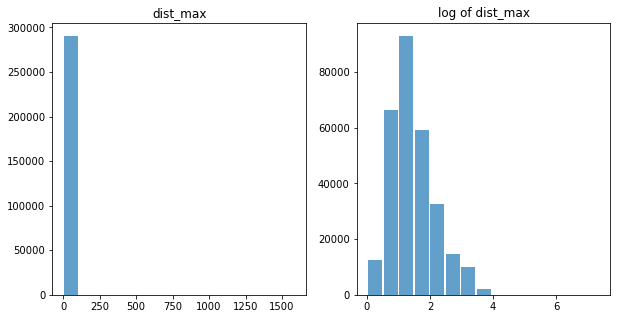

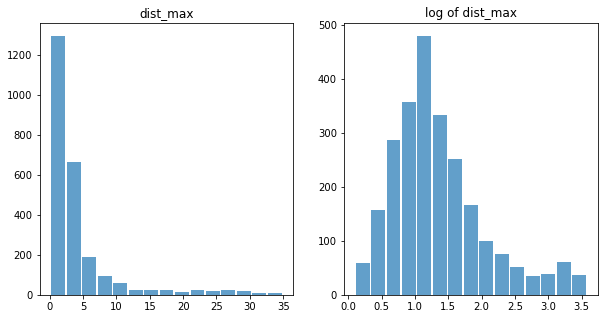

In [2500]:
# dist_max

train_hist_plot('dist_max', df_train)
test_hist_plot('dist_max', df_test)

In [2501]:
df_train['dist_max_log'] = np.log(df_train['dist_max'] + 1)
df_test['dist_max_log'] = np.log(df_test['dist_max'] + 1)

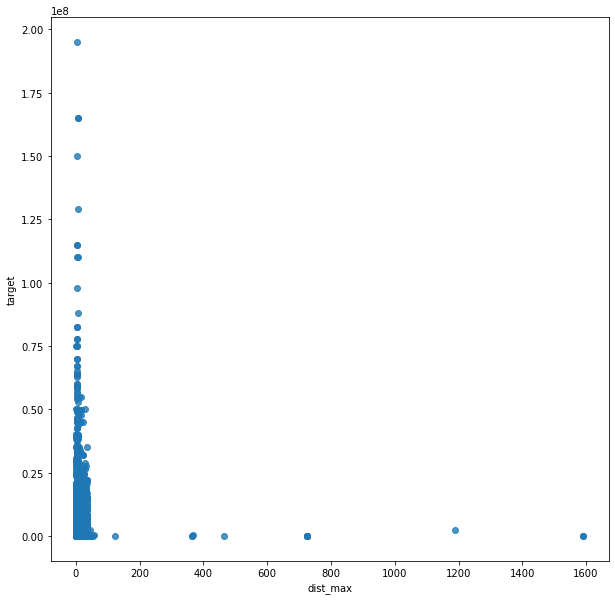

In [2502]:
plt.figure(figsize = (10,10))
sns.regplot(data=df_train, y="target", x="dist_max", fit_reg=False)
plt.show()

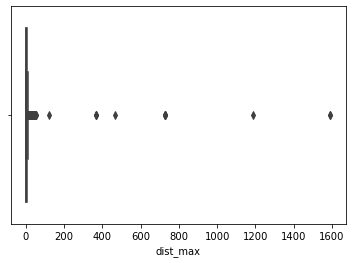

,name,count,min,mean,max,low_range,upper_range,out_count
1,dist_max,290422.0,0.02,4.69,1591.09,-3.73,10.56,27791.0


In [2503]:
# График выбросов
sns.boxplot(x=df_train["dist_max"])
plt.show()

# Выбросы
data_out[data_out['name'] == 'dist_max']

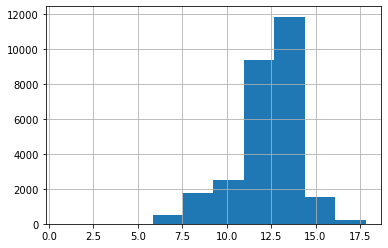

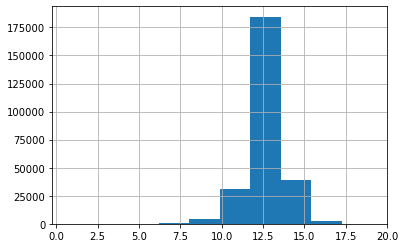

In [2504]:
df_train[df_train['dist_max'] > 10.56]['target_log'].hist()
plt.show()

df_train[df_train['dist_max'] <= 10.56]['target_log'].hist()
plt.show()

In [2505]:
# Цена распределена примерно одинакого, ничего с выбросами делать пока не будем

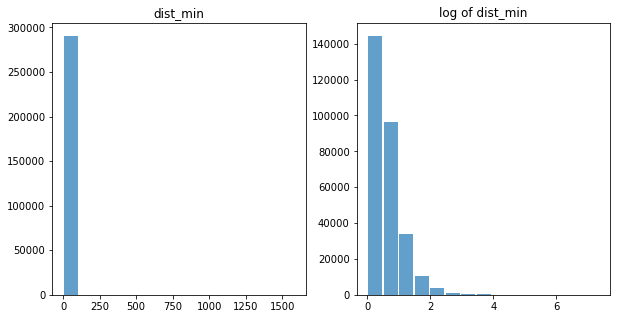

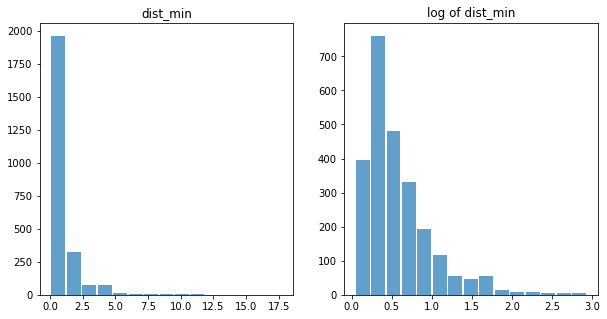

In [2506]:
# dist_min

train_hist_plot('dist_min', df_train)
test_hist_plot('dist_min', df_test)

In [2507]:
df_train['dist_min_log'] = np.log(df_train['dist_min'] + 1)
df_test['dist_min_log'] = np.log(df_test['dist_min'] + 1)

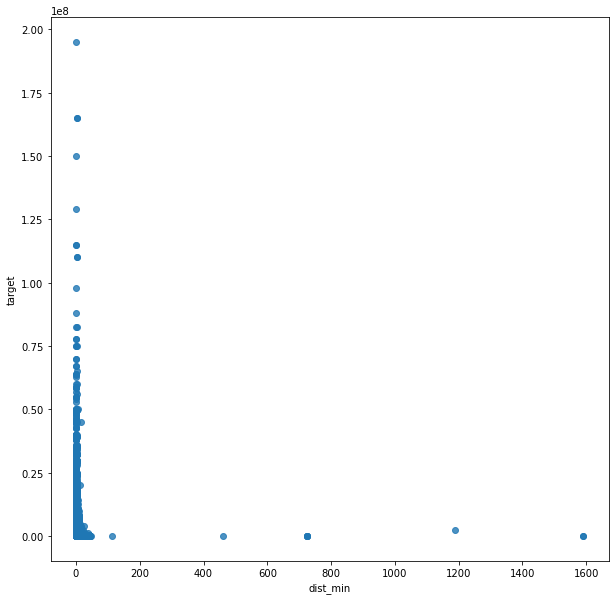

In [2508]:
plt.figure(figsize = (10,10))
sns.regplot(data=df_train, y="target", x="dist_min", fit_reg=False)
plt.show()

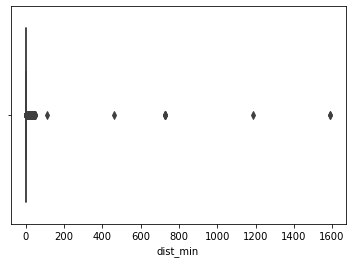

,name,count,min,mean,max,low_range,upper_range,out_count
2,dist_min,290422.0,0.01,1.19,1590.38,-1.04,2.68,24800.0


In [2509]:
# График выбросов
sns.boxplot(x=df_train["dist_min"])
plt.show()

# Выбросы
data_out[data_out['name'] == 'dist_min']

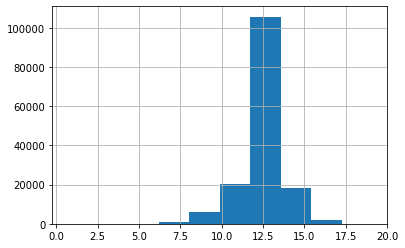

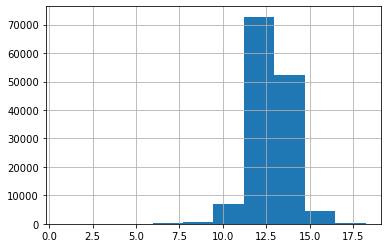

In [2510]:
df_train[df_train['dist_max'] > 2.68]['target_log'].hist()
plt.show()

df_train[df_train['dist_max'] <= 2.68]['target_log'].hist()
plt.show()

In [2511]:
# Цена распределена примерно одинакого, ничего с выбросами делать пока не будем

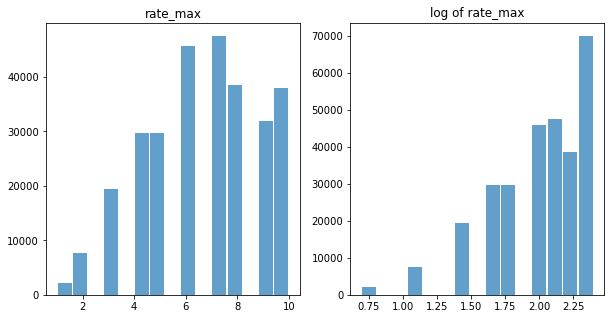

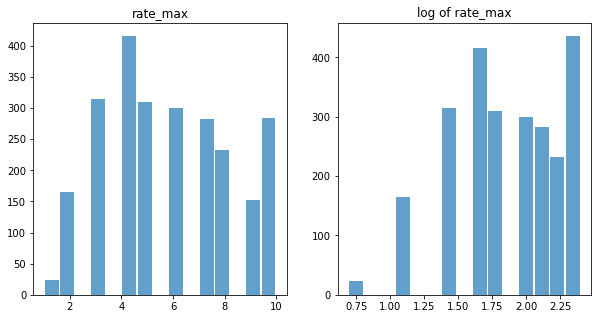

In [2512]:
# rate_max

train_hist_plot('rate_max', df_train)
test_hist_plot('rate_max', df_test)

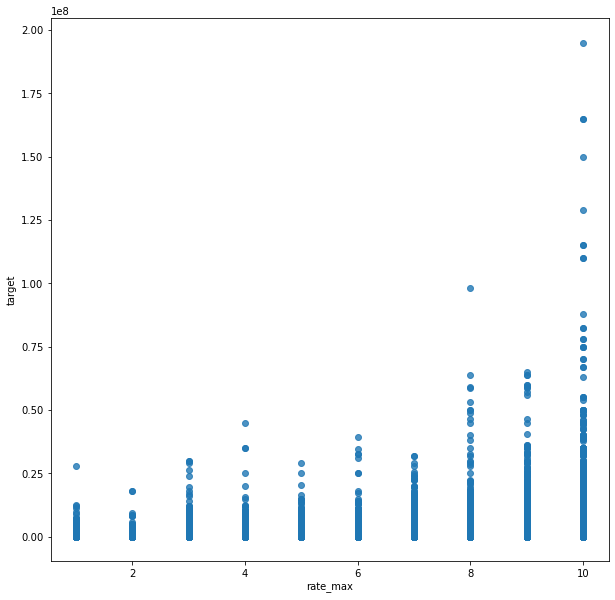

In [2513]:
plt.figure(figsize = (10,10))
sns.regplot(data=df_train, y="target", x="rate_max", fit_reg=False)
plt.show()

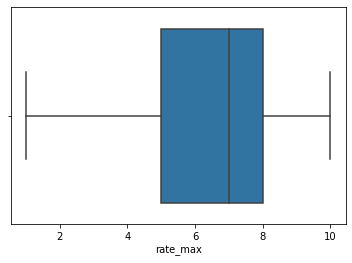

,name,count,min,mean,max,low_range,upper_range,out_count
3,rate_max,290422.0,1.0,6.63,10.0,0.5,12.5,0.0


In [2514]:
# График выбросов
sns.boxplot(x=df_train["rate_max"])
plt.show()

# Выбросы
data_out[data_out['name'] == 'rate_max']

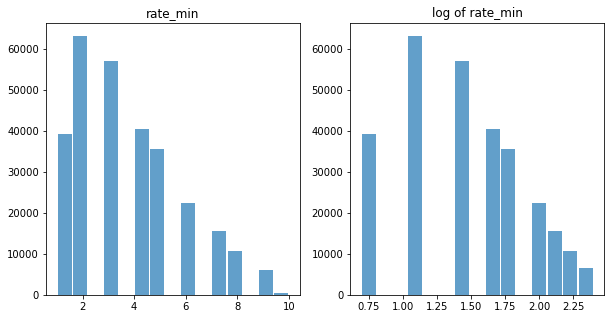

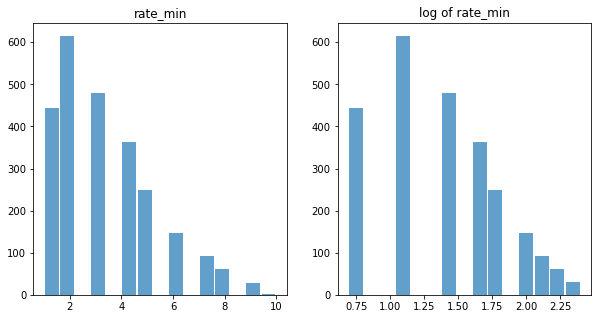

In [2515]:
# rate_min

train_hist_plot('rate_min', df_train)
test_hist_plot('rate_min', df_test)

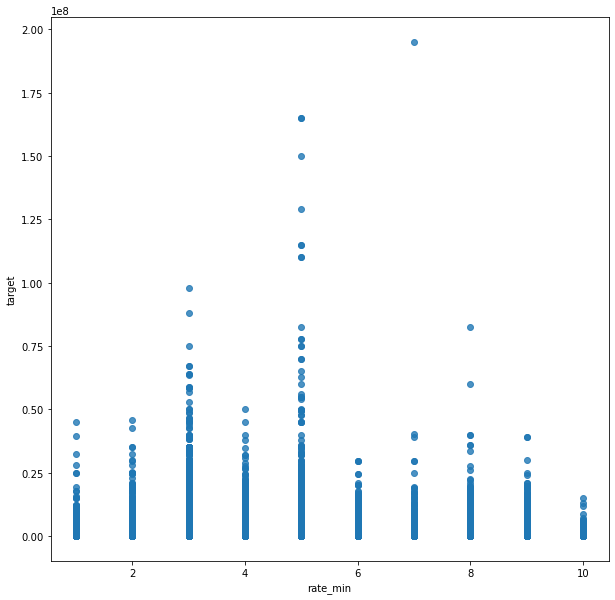

In [2516]:
plt.figure(figsize = (10,10))
sns.regplot(data=df_train, y="target", x="rate_min", fit_reg=False)
plt.show()

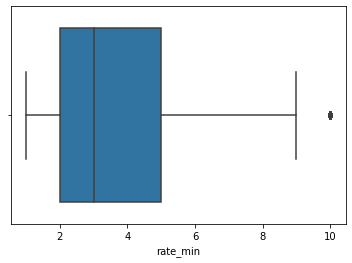

,name,count,min,mean,max,low_range,upper_range,out_count
4,rate_min,290422.0,1.0,3.66,10.0,-2.5,9.5,548.0


In [2517]:
# График выбросов
sns.boxplot(x=df_train["rate_min"])
plt.show()

# Выбросы
data_out[data_out['name'] == 'rate_min']

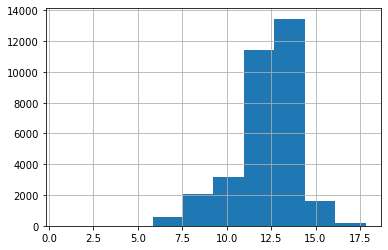

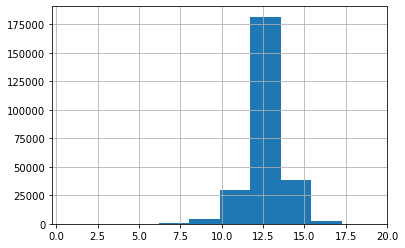

In [2518]:
df_train[df_train['dist_max'] > 9.5]['target_log'].hist()
plt.show()

df_train[df_train['dist_max'] <= 9.5]['target_log'].hist()
plt.show()

In [2519]:
# Цена распределена примерно одинакого, ничего с выбросами делать пока не будем

Влияние числовых признаков на target

In [2520]:
# df_train.columns

In [2521]:
# Введем новые числовые признаки
numerical_features_new = numerical_features + ['dist_max_log', 'dist_min_log' ,'sqft_log']

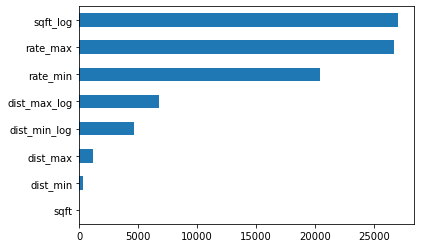

In [2522]:
# График влияния числовых переменных на target

df_train_imp = df_train.copy()

# рассмотрим значимость переменных

imp_num = pd.Series(f_regression(df_train_imp[numerical_features_new], 
                              df_train_imp['target_log'])[0], index=numerical_features_new)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [2523]:
# Видим что наибольшее значение имеет sqft_log, наименьшее sqft

In [2524]:
# График влияния числовых переменных на target

# df_train_imp = df_train.copy()

# # рассмотрим значимость переменных
# label_encoder = LabelEncoder()

# imp_num = pd.Series(mutual_info_regression(df_train_imp[numerical_features_new], 
#                               df_train_imp['target_log']), index=numerical_features_new)
# imp_num.sort_values(inplace = True)
# imp_num.plot(kind = 'barh')

Рассмаотрим категориальные переменные

In [2525]:
df_train['status'].value_counts()

for sale                          193263
active                             68337
foreclosure                         5864
new construction                    5207
pending                             4616
                                   ...  
conting accpt backups                  1
pending w backup wanted                1
contingent no show                     1
pending backup offer requested         1
pending backups wanted                 1
Name: status, Length: 95, dtype: int64

In [2526]:
df_test['status'].value_counts()

foreclosure                1410
recently sold               287
pre foreclosure auction     279
auction                     180
foreclosed                  165
pre foreclosure             119
new construction             16
closed                       13
pending                       5
for sale                      4
sold                          2
active                        1
Name: status, dtype: int64

In [2527]:
unique_train_stat = df_train['status'].unique()

df_test[~df_test['status'].isin(unique_stat)]['status'].value_counts()

recently sold    287
sold               2
Name: status, dtype: int64

In [2528]:
# Так как в трейне нет ничего похожего на sold, заменим на "for sale"

df_test.loc[df_test['status'].str.contains('sold'), 'status'] = 'for sale'

In [2529]:
unique_stat = df_test['status'].unique()

# Удаляем данные из трейна те значения, которых нет в тесте
df_train = df_train[df_train['status'].isin(unique_stat)]

In [2530]:
df_train['propertyType'].value_counts()

single family                                                                         153843
condo                                                                                  31689
lot land                                                                               19548
townhouse                                                                              14899
multi family                                                                           10453
                                                                                       ...  
multi generational ranch traditional                                                       1
condo town contemporary modern loft traditional                                            1
rustic spanish traditional                                                                 1
single detached mediterranean spanish traditional                                          1
designated historical single detached english french other see remarks

In [2531]:
df_test['propertyType'].value_counts()

single family                1994
condo                         157
apartment                     124
multi family                   48
townhouse                      48
singlefamilyresidence          41
lot land                       20
mobile manufactured            15
multiple occupancy             13
miscellaneous                   8
cooperative                     2
apartment condo townhouse       2
traditional                     1
coop                            1
contemporary                    1
other                           1
unknown                         1
colonial                        1
land                            1
mfd mobile                      1
federal                         1
Name: propertyType, dtype: int64

In [2532]:
unique_train_type = df_train['propertyType'].unique()

df_test[~df_test['propertyType'].isin(unique_train_type)]['propertyType'].value_counts()

apartment condo townhouse    2
Name: propertyType, dtype: int64

In [2533]:
# Так как количетсво этих значений мало, заменим на аналогичное из теста

df_test.loc[df_test['propertyType'] == 'apartment condo townhouse', 'propertyType'] = 'apartment'

In [2534]:
unique_type = df_test['propertyType'].unique()

# Удалим строки из трейна, где нет значений из теста
df_train = df_train[df_train['propertyType'].isin(unique_type)]

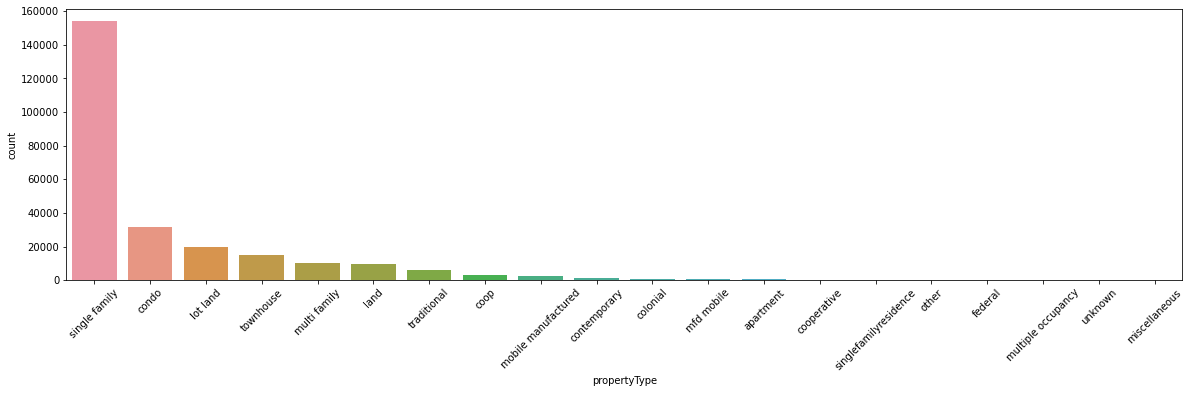

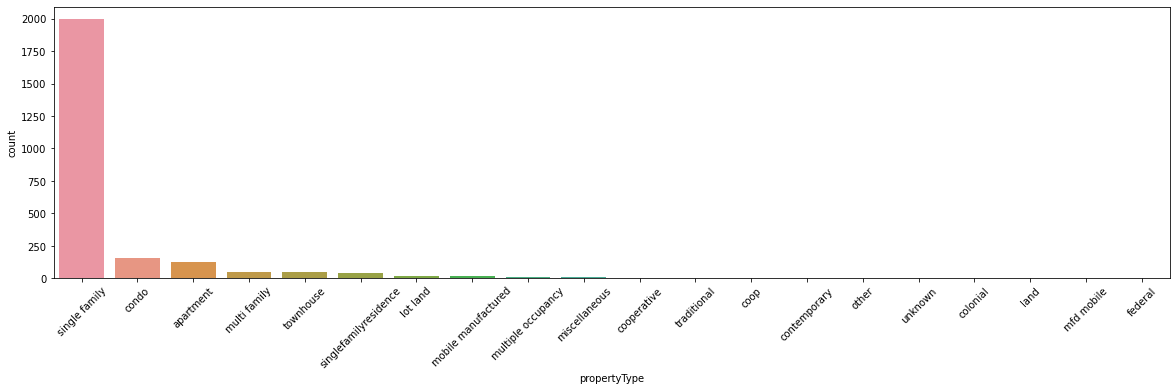

In [2535]:
# Посмотрим как распределены значения в трейне и тесте
plt.figure(figsize=(20, 5))
sns.countplot(x="propertyType", data=df_train, order = df_train['propertyType'].value_counts().index)
plt.xticks(rotation=45)
plt.show()


plt.figure(figsize=(20, 5))
sns.countplot(x="propertyType", data=df_test, order = df_test['propertyType'].value_counts().index)
plt.xticks(rotation=45)
plt.show()

In [2536]:
# В дальнейшем можно будет упростить значения, чтобы не было такого разброса

In [2537]:
df_train['city'].value_counts()

san antonio         17019
houston             13777
chicago              6470
las vegas            5841
miami                5812
                    ...  
dearborn heights        1
jonesville              1
neponsit                1
virginia gardens        1
hindman                 1
Name: city, Length: 1576, dtype: int64

In [2538]:
df_test['city'].value_counts()

san antonio            134
tampa                  125
jacksonville           123
miami                  113
washington              89
                      ... 
northridge               1
salineville              1
howard beach             1
south richmond hill      1
middleburg heights       1
Name: city, Length: 353, dtype: int64

In [2539]:
unique_train_city = df_train['city'].unique()

df_test[~df_test['city'].isin(unique_train_city)]['city'].value_counts()

china             1
blythe            1
unincorporated    1
sweetwater        1
sisters           1
salineville       1
Name: city, dtype: int64

In [2540]:
# Так как мало значений, заменим их всех на other, которое уже присутствует

df_test.loc[~df_test['city'].isin(unique_train_city),'city'] = 'other'

In [2541]:
# Удалим из трейна строки, где значений нет в тесте

unique_city = df_test['city'].unique()

df_train = df_train[df_train['city'].isin(unique_city)]

In [2542]:
# Нужно беднт сократить количество уникальных значений, их все равно слишком много!

In [2543]:
df_train['zipcode'].value_counts()

32137    1936
32164    1071
33131     851
77845     837
34746     787
         ... 
79942       1
91405       1
22039       1
43150       1
90742       1
Name: zipcode, Length: 2895, dtype: int64

In [2544]:
df_test['zipcode'].value_counts()

20019    22
33647    20
11201    19
32209    18
33712    17
         ..
94703     1
43610     1
44105     1
60633     1
76549     1
Name: zipcode, Length: 1163, dtype: int64

In [2554]:
# Так как количество уникальных значений слишком много, разделим из согласно правилу 3-2

df_train.loc[:,'zip_f'] = df_train['zipcode'].apply(lambda x: str(x)[:3])
df_test.loc[:,'zip_f'] = df_test['zipcode'].apply(lambda x: str(x)[:3])

df_train.loc[:,'zip_s'] = df_train['zipcode'].apply(lambda x: str(x)[3:])
df_test.loc[:,'zip_s'] = df_test['zipcode'].apply(lambda x: str(x)[3:])


In [2559]:
# Удалим те строки в трейне, которых нет в тесте

unique_zipf = df_test['zip_f'].unique()
unique_zips = df_test['zip_s'].unique()

df_train = df_train[df_train['zip_f'].isin(unique_zipf)]
df_train = df_train[df_train['zip_s'].isin(unique_zips)]


In [2560]:
# Нужно будет сократить количество уникальных значений, их сильно много

# Ввести новые признаки в датафрейм

In [2568]:
df_train['state'].value_counts()

FL    56290
TX    45356
CA    15717
NY    13965
NC    13210
TN    11066
WA     8358
NV     7690
IL     7091
OH     6644
GA     5386
PA     4727
CO     3448
MI     3399
DC     2854
IN     2848
OR     2281
MO      718
MA      651
UT      503
MD      128
VT      106
VA       87
ME       42
Name: state, dtype: int64

In [2562]:
df_test['state'].value_counts()

FL    782
TX    428
CA    178
OH    156
NY    140
TN    109
DC     89
IL     87
WA     87
NC     76
GA     64
NV     61
PA     51
MI     35
IN     34
MO     34
CO     27
MA     18
OR     11
MD      4
VT      4
UT      4
VA      1
ME      1
Name: state, dtype: int64

In [2566]:
# Посмотрим каких значений теста нет в трейне

unique_train_state = df_train['state'].unique()

df_test[~df_test['state'].isin(unique_train_state)]['state'].value_counts()

Series([], Name: state, dtype: int64)

In [2567]:
# Удалим те строки в трейне, которых нет в тесте

unique_state = df_test['state'].unique()

df_train = df_train[df_train['state'].isin(unique_state)]


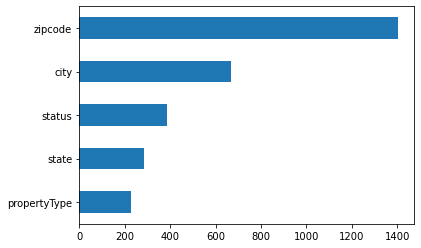

In [2569]:
# Теперь рассмотрим значимость категориальных переменных
df_train_cat = df_train.copy()

label_encoder = LabelEncoder()

for feature in categorical_features:
    df_train_cat[feature] = label_encoder.fit_transform(df_train_cat[feature])

imp_cat = pd.Series(f_regression(df_train_cat[categorical_features], 
                              df_train_cat['target_log'])[0], index=categorical_features)

imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [1308]:
# Замечание: влияние кат переменных на target и target_log разное

In [1309]:
# # Теперь рассмотрим значимость категориальных переменных

# df_train_cat = df_train.copy()

# # рассмотрим значимость переменных
# label_encoder = LabelEncoder()

# for feature in categorical_features:
#     df_train_cat[feature] = label_encoder.fit_transform(df_train_cat[feature])

# imp_cat = pd.Series(mutual_info_regression(df_train_cat[categorical_features], 
#                               df_train_cat['target_log']), index=numerical_features_new)
# imp_cat.sort_values(inplace = True)
# imp_cat.plot(kind = 'barh')

Prepocess data

In [1341]:
# features = categorical_features + numerical_features_new + ['target_log']
# df_input = pd.concat([df_train[features], df_test[features]])

# Удаляем признаки из numerical_features_new
for x in ['sqft', 'dist_max', 'dist_min', 'rate_max', 'rate_min']:
    numerical_features_new.remove(x)

for x in ['rate_max', 'rate_min']:
    categorical_features.append(x)
    
features = numerical_features_new + categorical_features + ['target_log']

In [1357]:
# Мы знаем, что у трейна нет target=0, все эти данные в тесте, поэтому можем легко их оюъединить

df_input = pd.concat([df_train[features], df_test[features]])

In [1359]:
df_input.sample(5)

,dist_max_log,dist_min_log,sqft_log,status,propertyType,city,zipcode,state,rate_max,rate_min,target_log
376135,0.955511,0.262364,7.297768,active,single family,tacoma,98406,WA,7.0,4.0,13.016783
225462,1.822935,0.239017,7.274480,for sale,single family,san antonio,78253,TX,8.0,7.0,12.337105
106615,1.398717,0.774727,8.192294,for sale,single family,indianapolis,46237,IN,7.0,5.0,12.873648
282569,0.693147,0.262364,7.910957,for sale,single family,houston,77070,TX,7.0,6.0,12.345839
346078,3.212858,0.672944,7.042286,for sale,condo,miami,33137,FL,10.0,2.0,13.190024


df_preproc = preproc_data(data)

In [1360]:
df_preproc = preproc_data(df_input, categorical_features)

In [1362]:
df_preproc.shape

(292903, 7101)

In [1366]:
# Мы видим, что при начальном количестве признаков, количество результирующих признаков слишком большое для теста
# Поэтому мы сразу удалим лишние признаки из трейна
# Возможно, потом удалим выбросы из трейна